# Step 0: モニター用のサンプルMLモデルを学習する

このノートブックを実行する時のヒント：   
- このノートブックは大容量のRawデータを読み込むため、<span style="color: orange; ">メモリー8GB以上のインスタンス</span>で実行してください
- KernelはPython3（Data Science）で動作確認をしています。
- デフォルトではSageMakerのデフォルトBucketを利用します。必要に応じて変更することも可能です。
- 実際に動かさなくても出力を確認できるようにセルのアウトプットを残しています。きれいな状態から実行したい場合は、右クリックメニューから "Clear All Outputs"を選択して出力をクリアしてから始めてください。

### 必要なライブラリーのインストールとインポート

In [ ]:
!pip install xgboost==1.5.1 optuna scikit-learn==1.0.2

In [3]:
import io
import boto3
import time
from datetime import datetime

import pandas as pd
import numpy as np
import sagemaker
from xgboost import XGBRegressor
from sklearn import metrics
import optuna

import model_utils

In [4]:
# SageMaker Default Bucketをセット
# 他のバケットを利用する場合はここを変更する
bucket = sagemaker.Session().default_bucket()

### トレーニング用のデータをオープンデータのS3バケットから取得

<span style="color: orange; font-size: 120% ">RAWデータ読み込み時に、メモリー4GBのインスタンスではメモリー不足によりカーネルが終了します</span>  
<span style="color: orange; font-size: 120% ">メモリーを8GB以上搭載したml.m5.largeなどのインスタンスを使用してください</span>  

In [5]:
%%time

start = '2019-07-01'
end = '2020-02-29'
sampling_rate = 20

df_features = pd.DataFrame()
for target in pd.date_range(start, end, freq='M'):
    print(target.year, target.month)
    
    # Get raw data with 20% sampling
    previous_year, previous_month = model_utils.get_previous_year_month(target.year, target.month)
    df_previous_month = model_utils.get_raw_data(previous_year, previous_month, sampling_rate)
    df_current_month = model_utils.get_raw_data(target.year, target.month, sampling_rate)
    df_data = pd.concat([df_previous_month, df_current_month]).reset_index(drop=True)
    del df_previous_month
    del df_current_month

    # Extract features
    df_features_current_month = model_utils.extract_features(df_data)
    df_features_current_month = model_utils.filter_current_month(df_features_current_month, target.year, target.month)
    
    df_features = pd.concat([df_features, df_features_current_month])

2019 7
2019 8
2019 9
2019 10
2019 11
2019 12
2020 1
2020 2
CPU times: user 2min 46s, sys: 32.7 s, total: 3min 19s
Wall time: 4min 32s


### データを期間で学習、検証、テストに分割し、ハイパーパラメーターチューニングを行う
ハイパーパラメーターチューニングはSageMakerでのトレーニングに組み込むことも可能ですが、今回はモデル作成をシンプルに実行するためにノートブック内で動かしています

In [6]:
# Split data for training
df_train = df_features[('2019-07-01'<=df_features.index) & (df_features.index <= '2019-12-31')].copy()
df_validation = df_features[('2020-01-01'<=df_features.index) & (df_features.index <= '2020-01-31')].copy()
df_test = df_features[('2020-02-01'<=df_features.index) & (df_features.index <= '2020-02-28')].copy()

y_train = df_train['pickup_count'].values
X_train = df_train[df_train.columns[1:]].values
y_validation = df_validation['pickup_count'].values
X_validation = df_validation[df_validation.columns[1:]].values
y_test = df_test['pickup_count'].values
X_test = df_test[df_test.columns[1:]].values

In [7]:
def objective(trial):
    
    params = {
        'objective': 'reg:squarederror',
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'alpha': trial.suggest_float('alpha', 0, 1000),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 120),
        'subsample': trial.suggest_float('subsample', 0.5, 1),
        'eta': trial.suggest_float('eta', 0.1, 0.5),
    }
    
    # Fit model
    bst = XGBRegressor(**params)
    bst.fit(X_train, y_train)
    
    # make predictions
    preds = bst.predict(X_validation)
    
    # Return target metric
    return np.sqrt(metrics.mean_squared_error(y_validation, preds))

# 最適なパラメーターを探すため、実行に20分ほどかかります。
study = optuna.create_study()
study.optimize(objective, n_trials=50)

[I 2022-12-15 10:37:31,273] A new study created in memory with name: no-name-df606950-889f-4535-a9f0-e4d1d7a52b19
[I 2022-12-15 10:37:49,796] Trial 0 finished with value: 77.77208361524062 and parameters: {'max_depth': 5, 'alpha': 595.7300746704884, 'min_child_weight': 120, 'subsample': 0.7158474569125317, 'eta': 0.3801220778920714}. Best is trial 0 with value: 77.77208361524062.
[I 2022-12-15 10:38:08,899] Trial 1 finished with value: 77.02380578750139 and parameters: {'max_depth': 5, 'alpha': 975.5350306481461, 'min_child_weight': 70, 'subsample': 0.7601596156492616, 'eta': 0.2363846460940136}. Best is trial 1 with value: 77.02380578750139.
[I 2022-12-15 10:38:25,763] Trial 2 finished with value: 81.88596838991234 and parameters: {'max_depth': 5, 'alpha': 209.82960645759752, 'min_child_weight': 90, 'subsample': 0.5929469916694439, 'eta': 0.489450686239459}. Best is trial 1 with value: 77.02380578750139.
[I 2022-12-15 10:38:49,537] Trial 3 finished with value: 75.84568397248532 and pa

In [8]:
bst = XGBRegressor(**study.best_params)
bst.fit(X_train, y_train)

print('Validation data')
validation_preds = bst.predict(X_validation)
model_utils.calc_accuracy(y_validation, validation_preds)

print('Test data')
test_preds = bst.predict(X_test)
model_utils.calc_accuracy(y_test, test_preds)

Validation data
RMSE: 72.87626544251876
MAE: 46.227257232512194
R2: 0.8969308192107929
Test data
RMSE: 50.24950549434309
MAE: 35.37940113033567
R2: 0.9549393007439243


In [9]:
best_params_str = {k: str(v) for k, v in study.best_params.items()}
best_params_str

{'max_depth': '7',
 'alpha': '17.446370432440684',
 'min_child_weight': '70',
 'subsample': '0.8197475403827663',
 'eta': '0.11950101013136272'}

### 得られたハイパーパラメーターを利用してモデルのトレーニングを行う

In [10]:
model_data_prefix = 'model_monitor/data/nyctaxi/model_training'

In [11]:
# Split data to train, validation and test, and save the data in S3
data_path = f's3://{bucket}/{model_data_prefix}'
train_data_file = 'data.train'
validation_data_file = 'data.validate'

# Upload train and validate data to s3
df_train.to_csv(f'./{train_data_file}', index=False, header=False)
resp = sagemaker.s3.S3Uploader.upload(f'./{train_data_file}', data_path)
print(resp)

df_validation.to_csv(f'./{validation_data_file}', index=False, header=False)
resp = sagemaker.s3.S3Uploader.upload(f'./{validation_data_file}', data_path)
print(resp)

s3://sagemaker-ap-northeast-1-370828233696/model_monitor/data/nyctaxi/model_training/data.train
s3://sagemaker-ap-northeast-1-370828233696/model_monitor/data/nyctaxi/model_training/data.validate


In [ ]:
%%time

# モデルの学習とエンドポイントのデプロイをまとめて行うので、実行に15分程度かかります

# Set environments for model training
role = sagemaker.get_execution_role()
region = boto3.Session().region_name
# container = get_image_uri(region, 'xgboost', '1.0-1')
container = sagemaker.image_uris.retrieve('xgboost', region, '1.5-1')

training_start_time = datetime.now().strftime('%Y-%m-%d-%H-%M-%S')

job_name = 'nyctaxi-xgboost-regression-' + training_start_time
model_prefix = 'model/nyctaxi-xgboost-regression'
print("Training job", job_name)

# Define model training parameters
create_training_params = \
{
    "AlgorithmSpecification": {
        "TrainingImage": container,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": f's3://{bucket}/{model_prefix}'
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.m5.large",
        "VolumeSizeInGB": 5
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        **best_params_str,
        "num_round":"1000"
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 3600
    },
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": f'{data_path}/{train_data_file}',
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "csv",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": f'{data_path}/{validation_data_file}',
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "csv",
            "CompressionType": "None"
        }
    ]
}

# Start model training
client = boto3.client('sagemaker', region_name=region)
client.create_training_job(**create_training_params)

# Wait for model training completion
status = client.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print(status)
while status !='Completed' and status!='Failed':
    time.sleep(60)
    status = client.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
    print(status)

# Create model
model_name=job_name + '-model'
info = client.describe_training_job(TrainingJobName=job_name)
model_data = info['ModelArtifacts']['S3ModelArtifacts']
primary_container = {
    'Image': container,
    'ModelDataUrl': model_data
}

create_model_response = client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])
print('Model creation completed.')
print('')

# Deploy model to endpoint
endpoint_name = 'nyctaxi-testing-endpoint-' + training_start_time
endpoint_config_name = 'nyctaxi-testing-endpoint-config-' + training_start_time
print('Endpoint deployment started.')

create_endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.t2.medium',
        'InitialVariantWeight':1,
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint name:', endpoint_name)
create_endpoint_response = client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name)

# Check endpoint creation status
resp = client.describe_endpoint(EndpointName=endpoint_name)
status = resp['EndpointStatus']
while status=='Creating':
    print("Status: " + status)
    time.sleep(60)
    resp = client.describe_endpoint(EndpointName=endpoint_name)
    status = resp['EndpointStatus']

print('Endpoint deployment completed.')
print('Endpoint arn:', resp['EndpointArn'])

Training job nyctaxi-xgboost-regression-2022-12-15-10-58-19
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
InProgress
Completed
arn:aws:sagemaker:ap-northeast-1:370828233696:model/nyctaxi-xgboost-regression-2022-12-15-10-58-19-model
Model creation completed.

Endpoint deployment started.
Endpoint name: nyctaxi-testing-endpoint-2022-12-15-10-58-19
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Status: Creating
Endpoint deployment completed.
Endpoint arn: arn:aws:sagemaker:ap-northeast-1:370828233696:endpoint/nyctaxi-testing-endpoint-2022-12-15-10-58-19
CPU times: user 265 ms, sys: 20.4 ms, total: 286 ms
Wall time: 14min 3s


In [ ]:
print('学習されたモデルの名前')
print(model_name)

学習されたモデルの名前
nyctaxi-xgboost-regression-2022-12-15-10-58-19-model


- <span style="color: orange; ">ここで作成したモデルの名前を、データ品質やモデル品質のモニタリング時に設定してください。</span>
- エンドポイントは学習時のテスト用なので、このノートブック以降では使用しません  

### デプロイした推論エンドポイントを使ってテストする

In [ ]:
df_test['timestamp'] = df_test.apply(lambda x: x.name + pd.offsets.Minute(x.time_slot*15), axis=1)
df_test = df_test.set_index('timestamp')
df_test

,pickup_count,history_12slots,history_16slots,history_20slots,history_24slots,history_28slots,history_32slots,history_36slots,history_40slots,history_44slots,...,tolls_amount_mean_12slot,tolls_amount_mean_16slot,tolls_amount_mean_20slot,tolls_amount_mean_96slot,tolls_amount_mean_100slot,tolls_amount_mean_104slot,tolls_amount_mean_192slot,tolls_amount_mean_196slot,tolls_amount_mean_200slot,time_slot
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-02-01 00:00:00,537,758.0,639.0,773.0,837.0,652.0,594.0,689.0,641.0,569.0,...,0.193127,0.239437,0.351979,0.313423,0.223082,0.242169,0.257931,0.290571,0.242643,0
2020-02-01 00:15:00,467,686.0,635.0,773.0,803.0,712.0,636.0,664.0,589.0,592.0,...,0.318950,0.240945,0.199884,0.232559,0.315537,0.273710,0.561222,0.251507,0.276241,1
2020-02-01 00:30:00,461,613.0,636.0,733.0,850.0,720.0,621.0,618.0,686.0,611.0,...,0.219462,0.253349,0.195689,0.479963,0.247932,0.345783,0.175694,0.209829,0.268718,2
2020-02-01 00:45:00,435,653.0,770.0,656.0,822.0,827.0,605.0,628.0,654.0,614.0,...,0.212894,0.288740,0.179558,0.528936,0.148938,0.314701,0.267750,0.362395,0.206045,3
2020-02-01 01:00:00,444,608.0,758.0,639.0,773.0,837.0,652.0,594.0,689.0,641.0,...,0.245378,0.193127,0.239437,0.787042,0.313423,0.223082,0.138045,0.257931,0.290571,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-02-28 22:45:00,727,789.0,899.0,879.0,646.0,650.0,700.0,661.0,589.0,626.0,...,0.174195,0.190456,0.258225,0.405913,0.353292,0.312892,0.296960,0.198254,0.237768,91
2020-02-28 23:00:00,732,677.0,911.0,857.0,739.0,708.0,673.0,657.0,590.0,610.0,...,0.273648,0.261844,0.218833,0.360368,0.347987,0.210449,0.227228,0.206366,0.269820,92
2020-02-28 23:15:00,651,629.0,879.0,882.0,763.0,636.0,713.0,603.0,618.0,571.0,...,0.297361,0.158965,0.251508,0.376248,0.401356,0.303953,0.166909,0.228785,0.255742,93


RMSE: 52.072790599634025
MAE: 37.37686011904762
R2: 0.9516099526556806


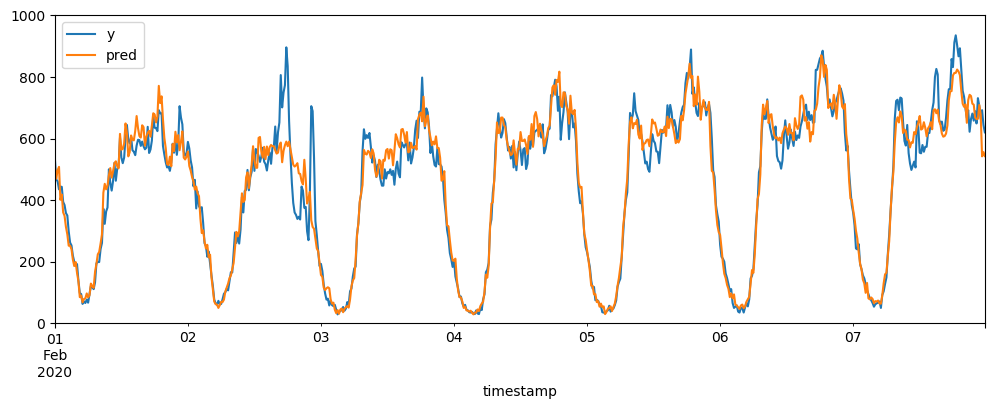

In [ ]:
%matplotlib inline

# Exec prediction
df_test[['pred', 'inference_id']] = model_utils.exec_prediction(endpoint_name, df_test)
model_utils.calc_accuracy(df_test.pickup_count, df_test.pred)
df_graph = df_test[:24*7*4]

# plot
pd.DataFrame({'y': df_graph.pickup_count, 'pred': df_graph.pred}).plot(ylim=(0,1000), figsize=(12,4))

### データ品質のためのベースライン・データセットをアップロードする
このデータセットには推論結果は含めません。推論結果を含めてしまうと、推論リクエスト時に渡す特徴量の数と食い違うので、エラーが発生します。

In [ ]:
# Upload feature data for baseline job
df_features.to_csv(f'./features-2019.csv', index=False)
sagemaker.s3.S3Uploader.upload(f'./features-2019.csv', f's3://{bucket}/model_monitor/data_quality_baseline_input')

's3://sagemaker-ap-northeast-1-370828233696/model_monitor/data_quality_baseline_input/features-2019.csv'

### モデル品質のためのベースライン・データセットをアップロードする
モデル品質のためのデータセットには推論結果が必要なので、推論結果を保持したDataFrameの内容をアップロードします。

In [ ]:
# Upload feature data for baseline job
df_test.to_csv(f'./test.csv', index=False)
sagemaker.s3.S3Uploader.upload(f'./test.csv', f's3://{bucket}/model_monitor/model_quality_baseline_input')

's3://sagemaker-ap-northeast-1-370828233696/model_monitor/model_quality_baseline_input/test.csv'

# 対話的データ分析の参考コード

In [1]:
import matplotlib.pyplot as plt
import boto3
import pandas as pd
import seaborn as sns

import model_utils

%matplotlib inline

### 2021年8月のデータを取得して傾向を調査

In [2]:
df_raw = model_utils.get_raw_data(2021, 8, sampling_rate=20)

# Remove abnormal records
df_raw = df_raw[0<df_raw.fare_amount]
df_raw = df_raw[(0<df_raw.trip_distance) & (df_raw.trip_distance<100)].copy()

df_raw['pickup_date_hour'] = pd.to_datetime(df_raw.tpep_pickup_datetime.dt.strftime('%Y-%m-%d-%H:00:00'))
df_raw['hour'] = df_raw['pickup_date_hour'].dt.hour
df_raw.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_date_hour,hour
118021,1,2021-08-02 16:51:58,2021-08-02 16:57:30,1.0,1.10,1.0,N,229,137,1,...,3.5,0.5,2.06,0.00,0.3,12.36,2.5,0.0,2021-08-02 16:00:00,16
1873676,1,2021-08-22 19:22:17,2021-08-22 19:50:23,1.0,18.10,2.0,N,132,230,1,...,2.5,0.5,12.35,6.55,0.3,74.20,2.5,0.0,2021-08-22 19:00:00,19
948739,1,2021-08-12 04:27:49,2021-08-12 04:36:36,1.0,3.20,1.0,N,74,126,2,...,0.5,0.5,0.00,0.00,0.3,12.30,0.0,0.0,2021-08-12 04:00:00,4
2060902,2,2021-08-25 09:16:46,2021-08-25 09:42:36,1.0,5.33,1.0,N,151,164,1,...,0.0,0.5,4.96,0.00,0.3,29.76,2.5,0.0,2021-08-25 09:00:00,9
658824,1,2021-08-08 18:39:17,2021-08-08 18:42:05,2.0,0.40,1.0,N,236,236,1,...,2.5,0.5,1.45,0.00,0.3,8.75,2.5,0.0,2021-08-08 18:00:00,18


### 平日3日間の乗車数推移

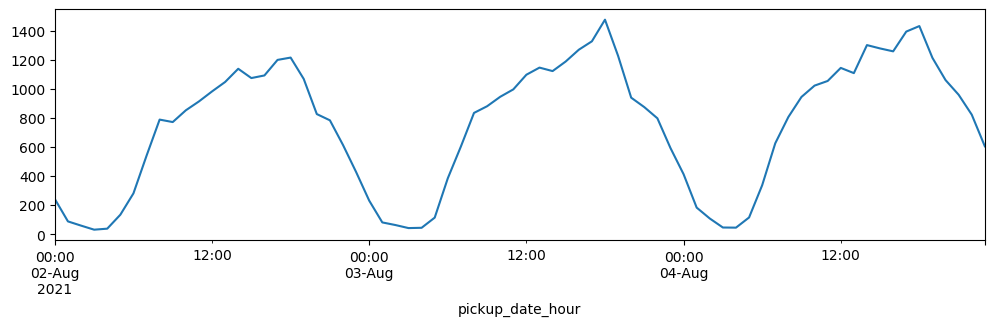

In [3]:
df_3days = df_raw[('2021-8-02' <= df_raw.tpep_pickup_datetime) & (df_raw.tpep_pickup_datetime < '2021-08-05')].sort_values(by='pickup_date_hour').copy()
df_3days.groupby(by='pickup_date_hour')['VendorID'].count().plot(figsize=(12,3))

### 時間帯ごとの乗車料金の推移をプロット

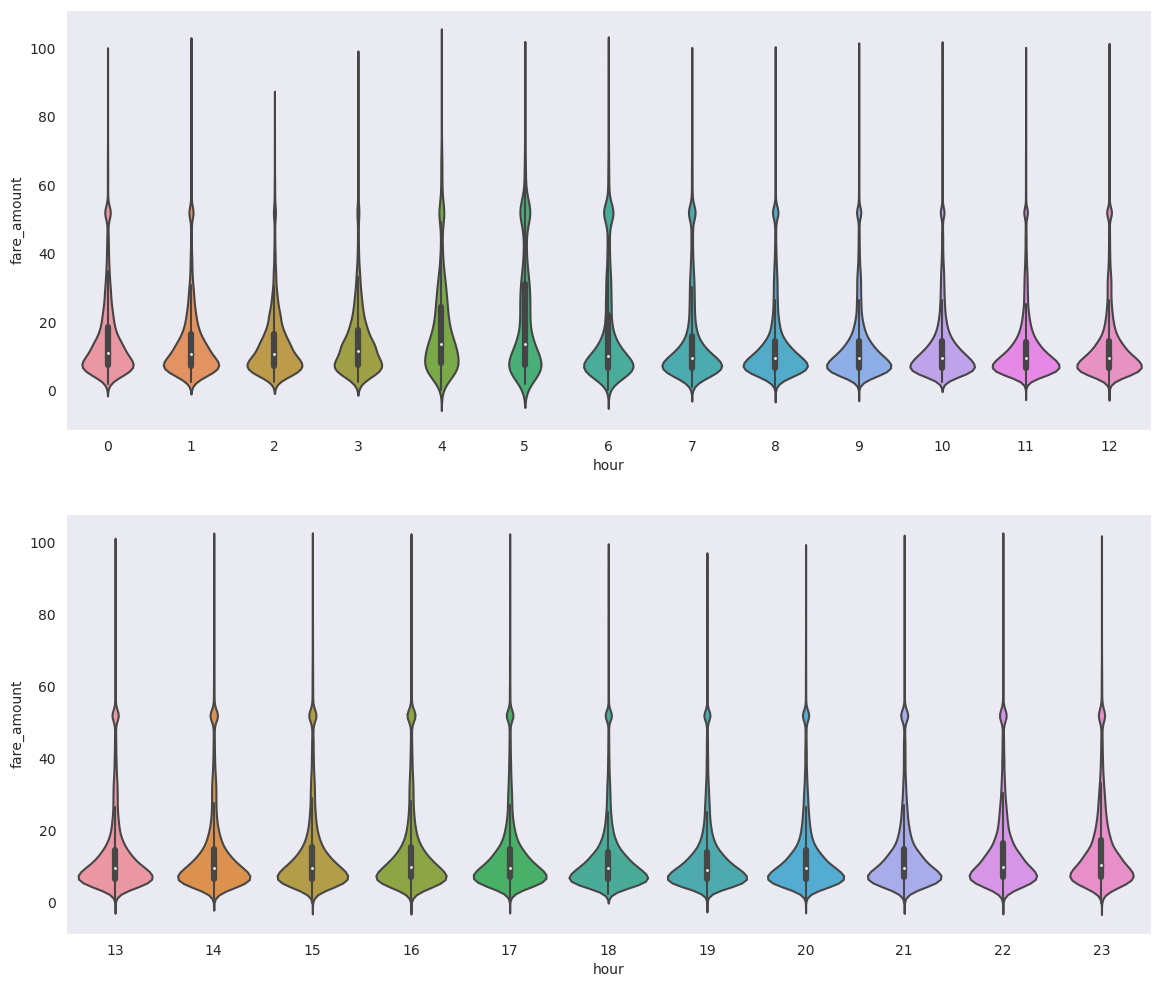

In [30]:
df_data = df_raw[df_raw.fare_amount<100]
fig, axes = plt.subplots(2,1, figsize=(14, 12))

for ax, start, end in zip(axes, [0,13], [13,24]):
    df_plot = df_data[(start<=df_data.hour) & (df_data.hour<end)]
    sns.violinplot(data=df_plot, x='hour', y='fare_amount', ax=ax)

### 特定の1日に絞って乗車料金とタクシー乗車数の連動をプロット

In [4]:
df_1day = df_raw[('2021-8-02' <= df_raw.tpep_pickup_datetime) & (df_raw.tpep_pickup_datetime < '2021-08-03')].sort_values(by='pickup_date_hour').copy()
df_1day.tail(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_date_hour,hour
147820,1,2021-08-02 23:56:53,2021-08-03 00:24:30,1.0,11.50,1.0,N,138,48,1,...,4.25,0.5,1.00,6.55,0.3,46.60,2.5,1.25,2021-08-02 23:00:00,23
2660769,1,2021-08-02 23:01:33,2021-08-02 23:24:18,NaN,15.10,NaN,None,132,145,0,...,1.75,0.5,8.71,0.00,0.3,52.26,NaN,NaN,2021-08-02 23:00:00,23
2660798,2,2021-08-02 23:28:23,2021-08-02 23:48:50,NaN,5.49,NaN,None,4,265,0,...,0.00,0.5,5.68,0.00,0.3,34.23,NaN,NaN,2021-08-02 23:00:00,23
147845,2,2021-08-02 23:49:04,2021-08-02 23:53:29,1.0,1.42,1.0,N,68,48,1,...,0.50,0.5,1.96,0.00,0.3,11.76,2.5,0.00,2021-08-02 23:00:00,23
147486,2,2021-08-02 23:38:17,2021-08-02 23:44:20,1.0,0.71,1.0,N,237,140,2,...,0.50,0.5,0.00,0.00,0.3,9.80,2.5,0.00,2021-08-02 23:00:00,23


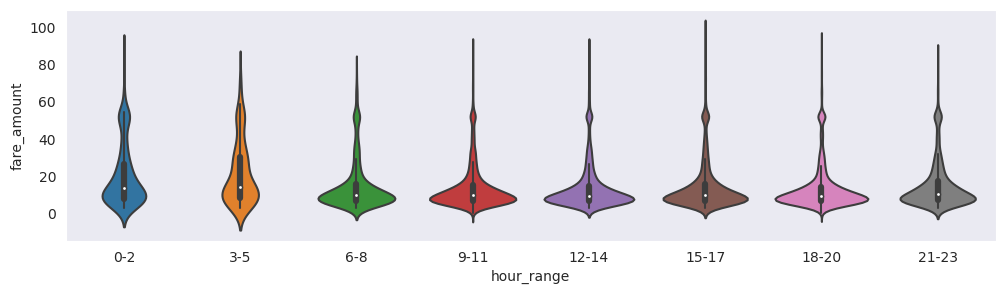

In [8]:
df_fare = df_1day[df_1day.fare_amount<100].copy()

def hour_range(hour):
    for i in range(3,25,3):
        if hour<i:
            return '{}-{}'.format(i-3, i-1)

df_fare['hour_range'] = df_fare.hour.apply(hour_range)
plt.figure(figsize=(12, 3))
sns.set_style('dark')
sns.violinplot(data=df_fare, x='hour_range', y='fare_amount')

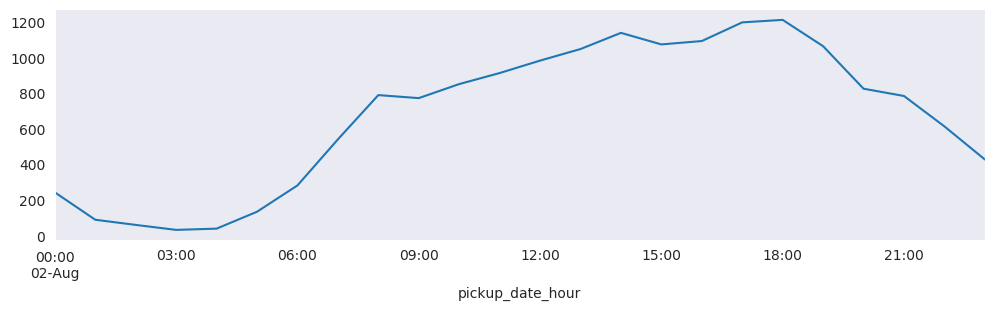

In [9]:
df_fare.groupby(by='pickup_date_hour')['VendorID'].count().plot(figsize=(12,3))

### 特定の2日間に絞って乗車料金とタクシー乗車数の連動をプロット

In [25]:
df_2days = df_raw[('2021-8-02' <= df_raw.tpep_pickup_datetime) & (df_raw.tpep_pickup_datetime < '2021-08-04')].sort_values(by='pickup_date_hour').copy()
df_2days.head(5)

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,pickup_date_hour,hour
68575,2,2021-08-02 00:07:51,2021-08-02 00:28:53,1.0,6.22,1.0,N,234,49,2,...,0.5,0.5,0.00,0.00,0.3,24.30,2.5,0.00,2021-08-02,0
70087,2,2021-08-02 00:09:40,2021-08-02 00:42:29,1.0,20.50,2.0,N,132,238,1,...,0.0,0.5,12.12,6.55,0.3,72.72,0.0,1.25,2021-08-02,0
70270,2,2021-08-02 00:29:32,2021-08-02 00:38:14,1.0,1.62,1.0,N,114,246,2,...,0.5,0.5,0.00,0.00,0.3,11.80,2.5,0.00,2021-08-02,0
69723,2,2021-08-02 00:09:47,2021-08-02 00:16:51,1.0,2.99,1.0,N,170,263,1,...,0.5,0.5,5.32,0.00,0.3,18.62,2.5,0.00,2021-08-02,0
69539,1,2021-08-02 00:31:53,2021-08-02 00:42:49,1.0,2.50,1.0,N,186,143,1,...,3.0,0.5,2.85,0.00,0.3,17.15,2.5,0.00,2021-08-02,0


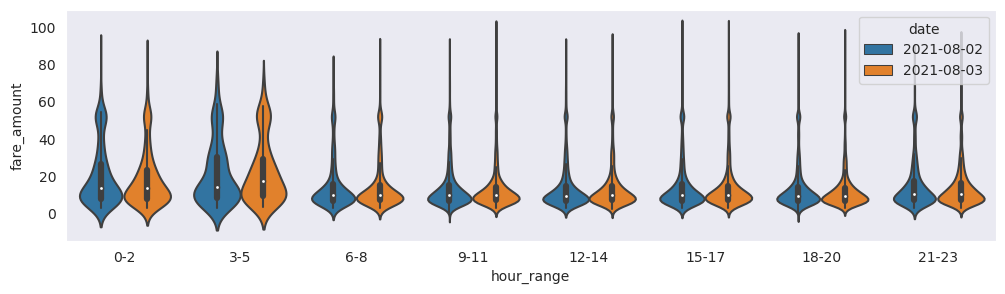

In [26]:
df_fare = df_2days[df_2days.fare_amount<100].copy()

def hour_range(hour):
    for i in range(3,25,3):
        if hour<i:
            return '{}-{}'.format(i-3, i-1)

df_fare['hour_range'] = df_fare.hour.apply(hour_range)
df_fare['date'] = df_fare.pickup_date_hour.dt.date
plt.figure(figsize=(12, 3))
sns.set_style('dark')
sns.violinplot(data=df_fare, x='hour_range', y='fare_amount', hue='date')

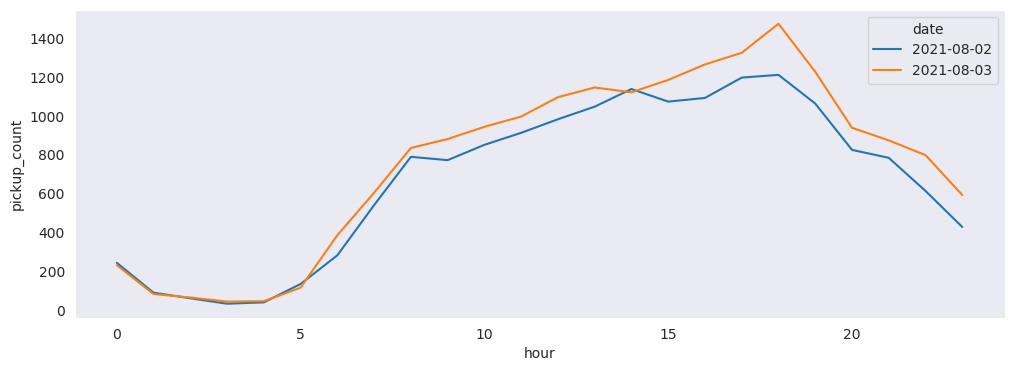

In [28]:
df_count = pd.DataFrame()
g = df_fare.groupby(by='pickup_date_hour')
df_count['pickup_count'] = g['VendorID'].count()
df_count['hour'] = df_count.index.hour
df_count['date'] = df_count.index.date

plt.figure(figsize=(12, 4))
sns.lineplot(data=df_count, x='hour', y='pickup_count', hue='date')